<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#-Комментарий-студента" data-toc-modified-id="-Комментарий-студента-3"><span class="toc-item-num">3&nbsp;&nbsp;</span> Комментарий студента</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#-Комментарий-студента" data-toc-modified-id="-Комментарий-студента-5"><span class="toc-item-num">5&nbsp;&nbsp;</span> Комментарий студента</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импорт нужных библиотек и функций:

In [112]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

Импорт и изучение данных:

In [113]:
df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропуски в столбце с возрастом клиента. Предлагаю заменить пропуски с привязкой к возрасту. Предпопложим, что в среднем человек начинает трудовую деятельность и активную финансовую в том числе после окончания ВУЗа, а это примерно 23 года. Заменим пропуски в столбце пропусков значением возраста минус 23. Но сначала следует взглянуть на адекватность значений возраста.

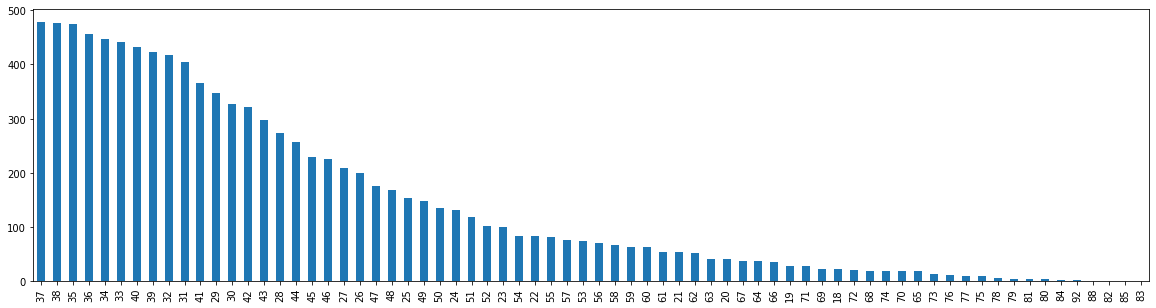

In [114]:
df['Age'].value_counts().plot(figsize=(20, 5), kind='bar')

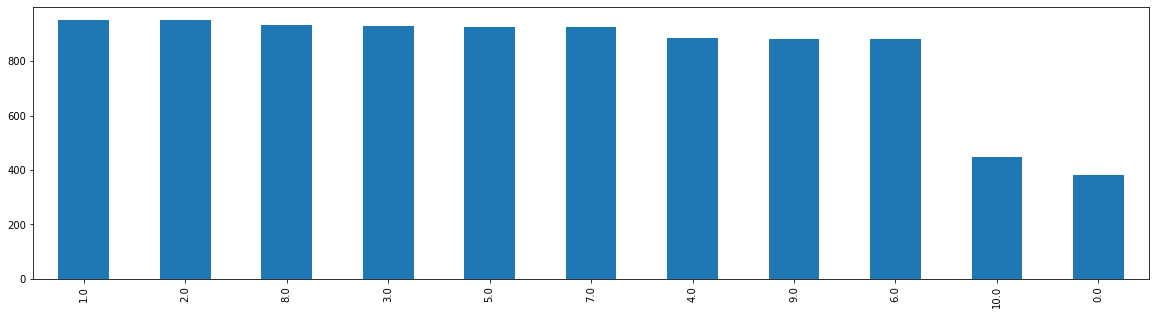

In [115]:
df['Tenure'].value_counts().plot(figsize=(20, 5), kind='bar')

Хм, интересно... Исследовать данные мне нравится все больше и больше. На первом графике видно, что основная масса клиентов имеют возраст 30-40 лет. Далее по убыванию 40, 50 и т.д. Однако из второго графика видно что банку всего 10 лет, так как самые преданные клиенты с банком именно 10 лет. Поскольку колчисетво клиентов с разным количеством лет в банке является примерно одинаковым (около 900 человек), значит каждый год в банк приходило примерно 900 человек. Предположим что люди одного возраста приходят в банк. Соотнесем 10-ти летний разборс опыта банковского обслуживания с самым популярным возрастом клиентов, получается люди идут в этот банк примерно в 30 лет. Возьмем эту цифру за основание для вычисления количества лет в банке. 

Но сначала посмотрим на возраст клиентов, у которых не указано количество лет общения с банком:

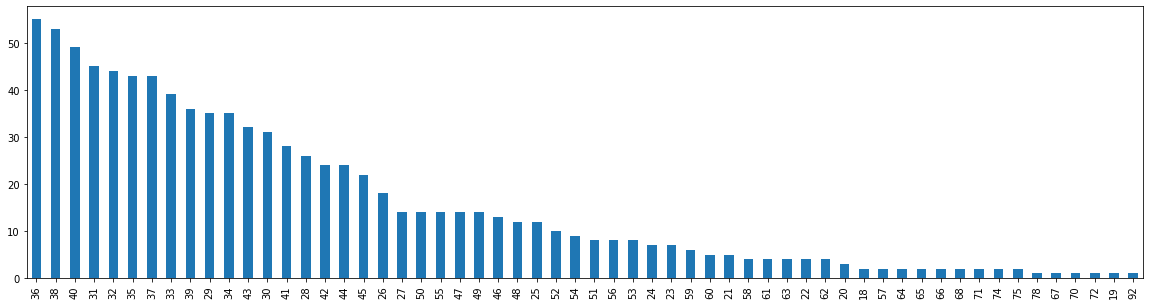

In [116]:
df_isna = df[df['Tenure'].isna()]
df_isna['Age'].value_counts().plot(figsize=(20, 5), kind='bar')

Нет. Предложенный способ не подойдет, поскольку слишком большой будет разброс значений. Пожалуй, остается только заполнить пропуски случайными значениями от 0 до 10, чтобы избежать перекоса данных.

In [117]:
# заполним пропуски случайными значениями:
df.loc[df['Tenure'].isna(), 'Tenure'] = pd.Series(np.random.randint(0, 10, len(df)))

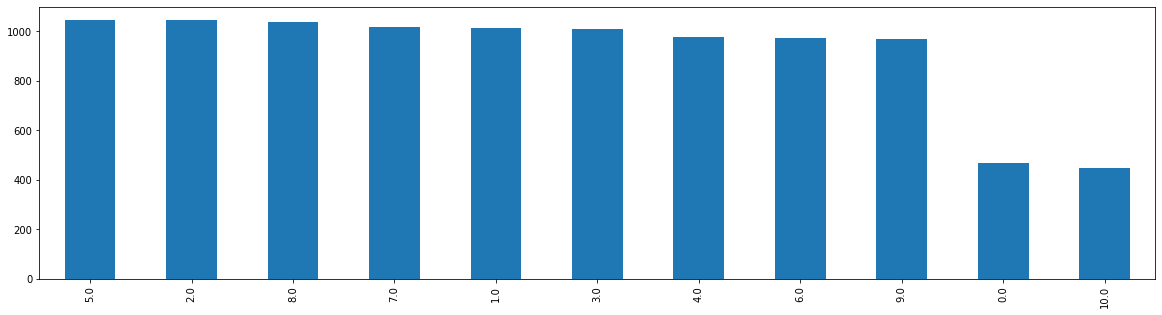

In [118]:
# проверим распределение после заполнения пропусков:
df['Tenure'].value_counts().plot(figsize=(20, 5), kind='bar')

In [119]:
# и проверим уникальные значения:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

Теперь с пропусками все ок. По привычке проверю дубликаты

In [120]:
df.duplicated().sum()

0

С ними тоже все хорошо. Глазу не нравится "ВерблюжийРегистр" в названии столбцов. Так как нам не хватает "пробелов", то перепишем вручную:

In [121]:
df.rename(columns = {'RowNumber' : 'row_number', 'CustomerId' : 'customer_id', 
                   'Surname' : 'surname', 'CreditScore' : 'credit_score', 'Geography' : 'geography',
                   'Gender' : 'gender', 'Age' : 'age', 'Tenure' : 'tenure', 'Balance' : 'balance', 
                   'NumOfProducts' : 'num_of_products', 'HasCrCard' : 'has_cr_card', 
                   'IsActiveMember' : 'is_active_member', 'EstimatedSalary' : 'estimated_salary', 
                   'Exited' : 'exited'}, inplace = True)
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Ну и в конце удалим столбцы, которые нам врядли помогут в прогнозировании результата. Это данные о фамилии и id клиента:

In [122]:
df.drop(columns = ['customer_id', 'surname'], axis = 1, inplace=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
row_number          10000 non-null int64
credit_score        10000 non-null int64
geography           10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
tenure              10000 non-null float64
balance             10000 non-null float64
num_of_products     10000 non-null int64
has_cr_card         10000 non-null int64
is_active_member    10000 non-null int64
estimated_salary    10000 non-null float64
exited              10000 non-null int64
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


## Исследование задачи

Еще раз взглянем на датасет, чтобы узнать какие признаки нам нужно преобразовать.

In [123]:
df.head()

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Мы видим колонки с названием страной и полом клиента, которые нужна преобразовать в численные значения. Используем для этого прямое кодирование применив функцию get_dummies(). 

In [124]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,row_number,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,1,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Теперь разделим данные на выборки, тренировочную, валидационную и тестовую, предварительно выделив признаки и целевое значение

In [125]:
target = df['exited']
features = df.drop('exited', axis=1)

# сначала разделим данные на тренировочный и тестовый наборы:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

# теперь разделим тестовый на валидационный и тестовый:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

# проверим размеры датасетов
print(len(features_train))
print(len(features_valid))
print(len(features_test))

6000
2000
2000


Теперь необходимо масштабировать признаки. Используем StandartScaler()

In [126]:
# уберем предупреждение об ошибке
pd.options.mode.chained_assignment = None

# создадим переменную со списком столбцов для масштабирования
numeric = ['credit_score', 'balance', 'estimated_salary', 'age']
# думаю tenure не обязательно масштабировать, там разборс не так велик

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


features_train.head()

,row_number,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,7480,-0.886751,-0.373192,8.0,1.232271,1,1,0,-0.187705,0,1,1
3411,3412,0.608663,-0.183385,8.0,0.600563,1,0,0,-0.333945,0,0,0
6027,6028,2.052152,0.480939,3.0,1.027098,2,0,1,1.503095,1,0,1
1247,1248,-1.457915,-1.417129,6.0,-1.233163,2,1,0,-1.071061,0,0,1
3716,3717,0.130961,-1.132419,2.0,1.140475,1,0,0,1.524268,1,0,0


Теперь обучим модели и посчитаем метрику F1

In [127]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5295007564296521

Добавим метрику ROC-AUC

In [128]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.8146946207030045

Показатели случайного леса оставляют желать лучшего. Попробуем использовать регрессию

In [129]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.3270868824531516

Метрика ROC-AUC

In [130]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.7587179936970341

F1 хуже, а вот ROC-AUC лучше. Попробуем использовать решающее дерево

In [131]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

0.4976303317535545

Посмотрим на метрики ROC-AUC

In [132]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.6829281570781337

Как мы видим лучший показатель у случайного леса. Избавимся от дисбаланса классов и проведем испытание моделей еще раз. 

Проверим баланс классов:

In [133]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Видим что клиентов, которые ушли, почти в 4 раза меньше тех, что остались. Тревожная динамика, будем исправлять этот дисбаланс

## Борьба с дисбалансом

В первую очередь попробуем указать аргумент баланса классов в вызове модели

In [134]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.48465266558966075

Результат еще хуже. Пробуем увеличить выборку


In [135]:
# напишем функцию для увеличения выборки:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 6)

model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F1: 0.5352112676056339


ROC-AUC:

In [136]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.8082185048300559

Мы близки к результату. Лучший результат показывает увеличение меньшей выборки в 6 раз. Попробуем то же самое с деревом

In [137]:

features_upsampled, target_upsampled = upsample(features_train, target_train, 7)

model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5147058823529411


ROC-AUC:

In [138]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.6917777146002577

Максимальный результат получился на модели случайного леса. Попробуем усовершенствовать его, добавив глубины и количества деревьев

In [139]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)


model_random_forest = RandomForestClassifier(random_state=12345, n_estimators=7, class_weight='balanced', max_depth=6)
model_random_forest.fit(features_upsampled, target_upsampled)
predicted_valid = model_random_forest.predict(features_valid)
result = f1_score(target_valid, predicted_valid)   
result

0.6030150753768844

На валидационной выборке достигли желаемого результата, пора переходить к тестовой. Но сначала посомтрим на ROC-AUC

In [140]:
probabilities_valid = model_random_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.8454752629764274

Да, и ROC-AUC подтянулся, думаю пора переходить к тестовой выборке

## Тестирование модели

In [143]:
predicted_test = model_random_forest.predict(features_test)
result = f1_score(target_test, predicted_test)   
result

0.601593625498008

И финальный ROC-AUC

In [142]:
probabilities_valid = model_random_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.8454752629764274

Вывод. Мы добились нужных результатов. Можно заметить что F1 и ROC-AUC имеют прямую корреляцию. В нашем случае мы добились успеха только комбинацией борьбы с дисбалансом уровновешивания классов через class_weight='balanced' и увеличением тренировочной выборки. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*